<center><h1> Lab05 102062207 Regressor</h1></center>

This is a ipython notebook for my Lab05 codes.

In [3]:
%matplotlib inline

In [4]:
from pylab import *

In [20]:
class LassoRegressor(object):
    
    def __init__(self, eta=0.001, alpha=0.001, n_iter=40, random_state=1, zero=1e-10):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.zero = zero
        self.random_state = random_state
        
    def fit(self, X, y, stop_crit=10):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        cost = 1e+10
        N = X.shape[0]
        self.init_w_ = True
        
        # notes that self.w_[0] is the bias term
        for i in range(self.n_iter):
            output = self.predict(X)
            errors = (y - output)

            # calculate the SSE term
            SSE = self.eta * X.T.dot(errors)
            weights, cost = self.update_weights_(cost, errors, SSE, N, stop_crit)
            
            self.w_[1:] = weights
            self.w_[0] += self.eta * errors.sum()
            self.cost_.append(cost)
        
        return self
    
    def update_weights_(self, cost, errors, SSE, N, stop_crit):
        j = 0
        need_compute = True
        new_cost = 0
        SSE_ = self.w_[1:] + SSE / N
        
        while(new_cost > cost or need_compute) and (j < stop_crit):
            need_compute = False
            L1_sub = self.subgradient_()
            new_weights = SSE_ - L1_sub
            new_cost = (errors**2).sum() / (2.0 * N) + self.alpha * np.fabs(new_weights).sum()
            j += 1
            if self.init_w_:
                self.init_w_ = False
                break
        return new_weights, new_cost
        
        
    
    def subgradient_(self):
        subgrad = np.sign(self.w_[1:])
        subgrad[np.fabs(subgrad) < self.zero] = np.random.uniform(-1, 1)
        subgrad *= self.alpha * self.eta
        return subgrad
    
    def predict(self, X):
        # for x^0 to x^n 
        return np.dot(X, self.w_[1:]) + self.w_[0]

Now, let us test if our code works!
To do so, we read out the training data, we simply fit it into our new regressor, and plot the cost to make sure it can converge.

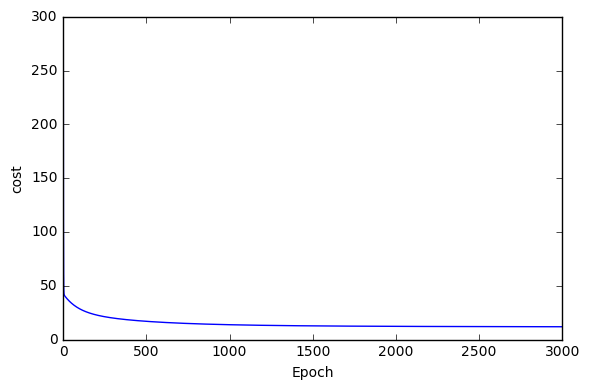

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

sc_x = StandardScaler()
sc_y = StandardScaler()
X_train = sc_x.fit_transform(train_set)
#y_train_std = sc_y.fit_transform(y_train)

llr = LassoRegressor(eta=0.001,alpha=0.001, n_iter=3000)
llr = llr.fit(X_train, y_train)


plt.plot(range(1, llr.n_iter+1), llr.cost_)
plt.ylabel('cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('./output/fig-lasso-cost.png', dpi=300)
plt.show()

In [45]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


y_train_pred = llr.predict(X_train)

print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(y_train, y_train_pred)))


MSE train: 23.68
R^2 train: 0.72


Great, it works, and will slowly converge. Now we can start tuning the performance. However, before we directly jump into the tuning process, we should first analyze the data. Since directly observing test set is not and should not be allowed, we only check analyze the training data.

In [30]:
import seaborn as sns
import pandas as pd

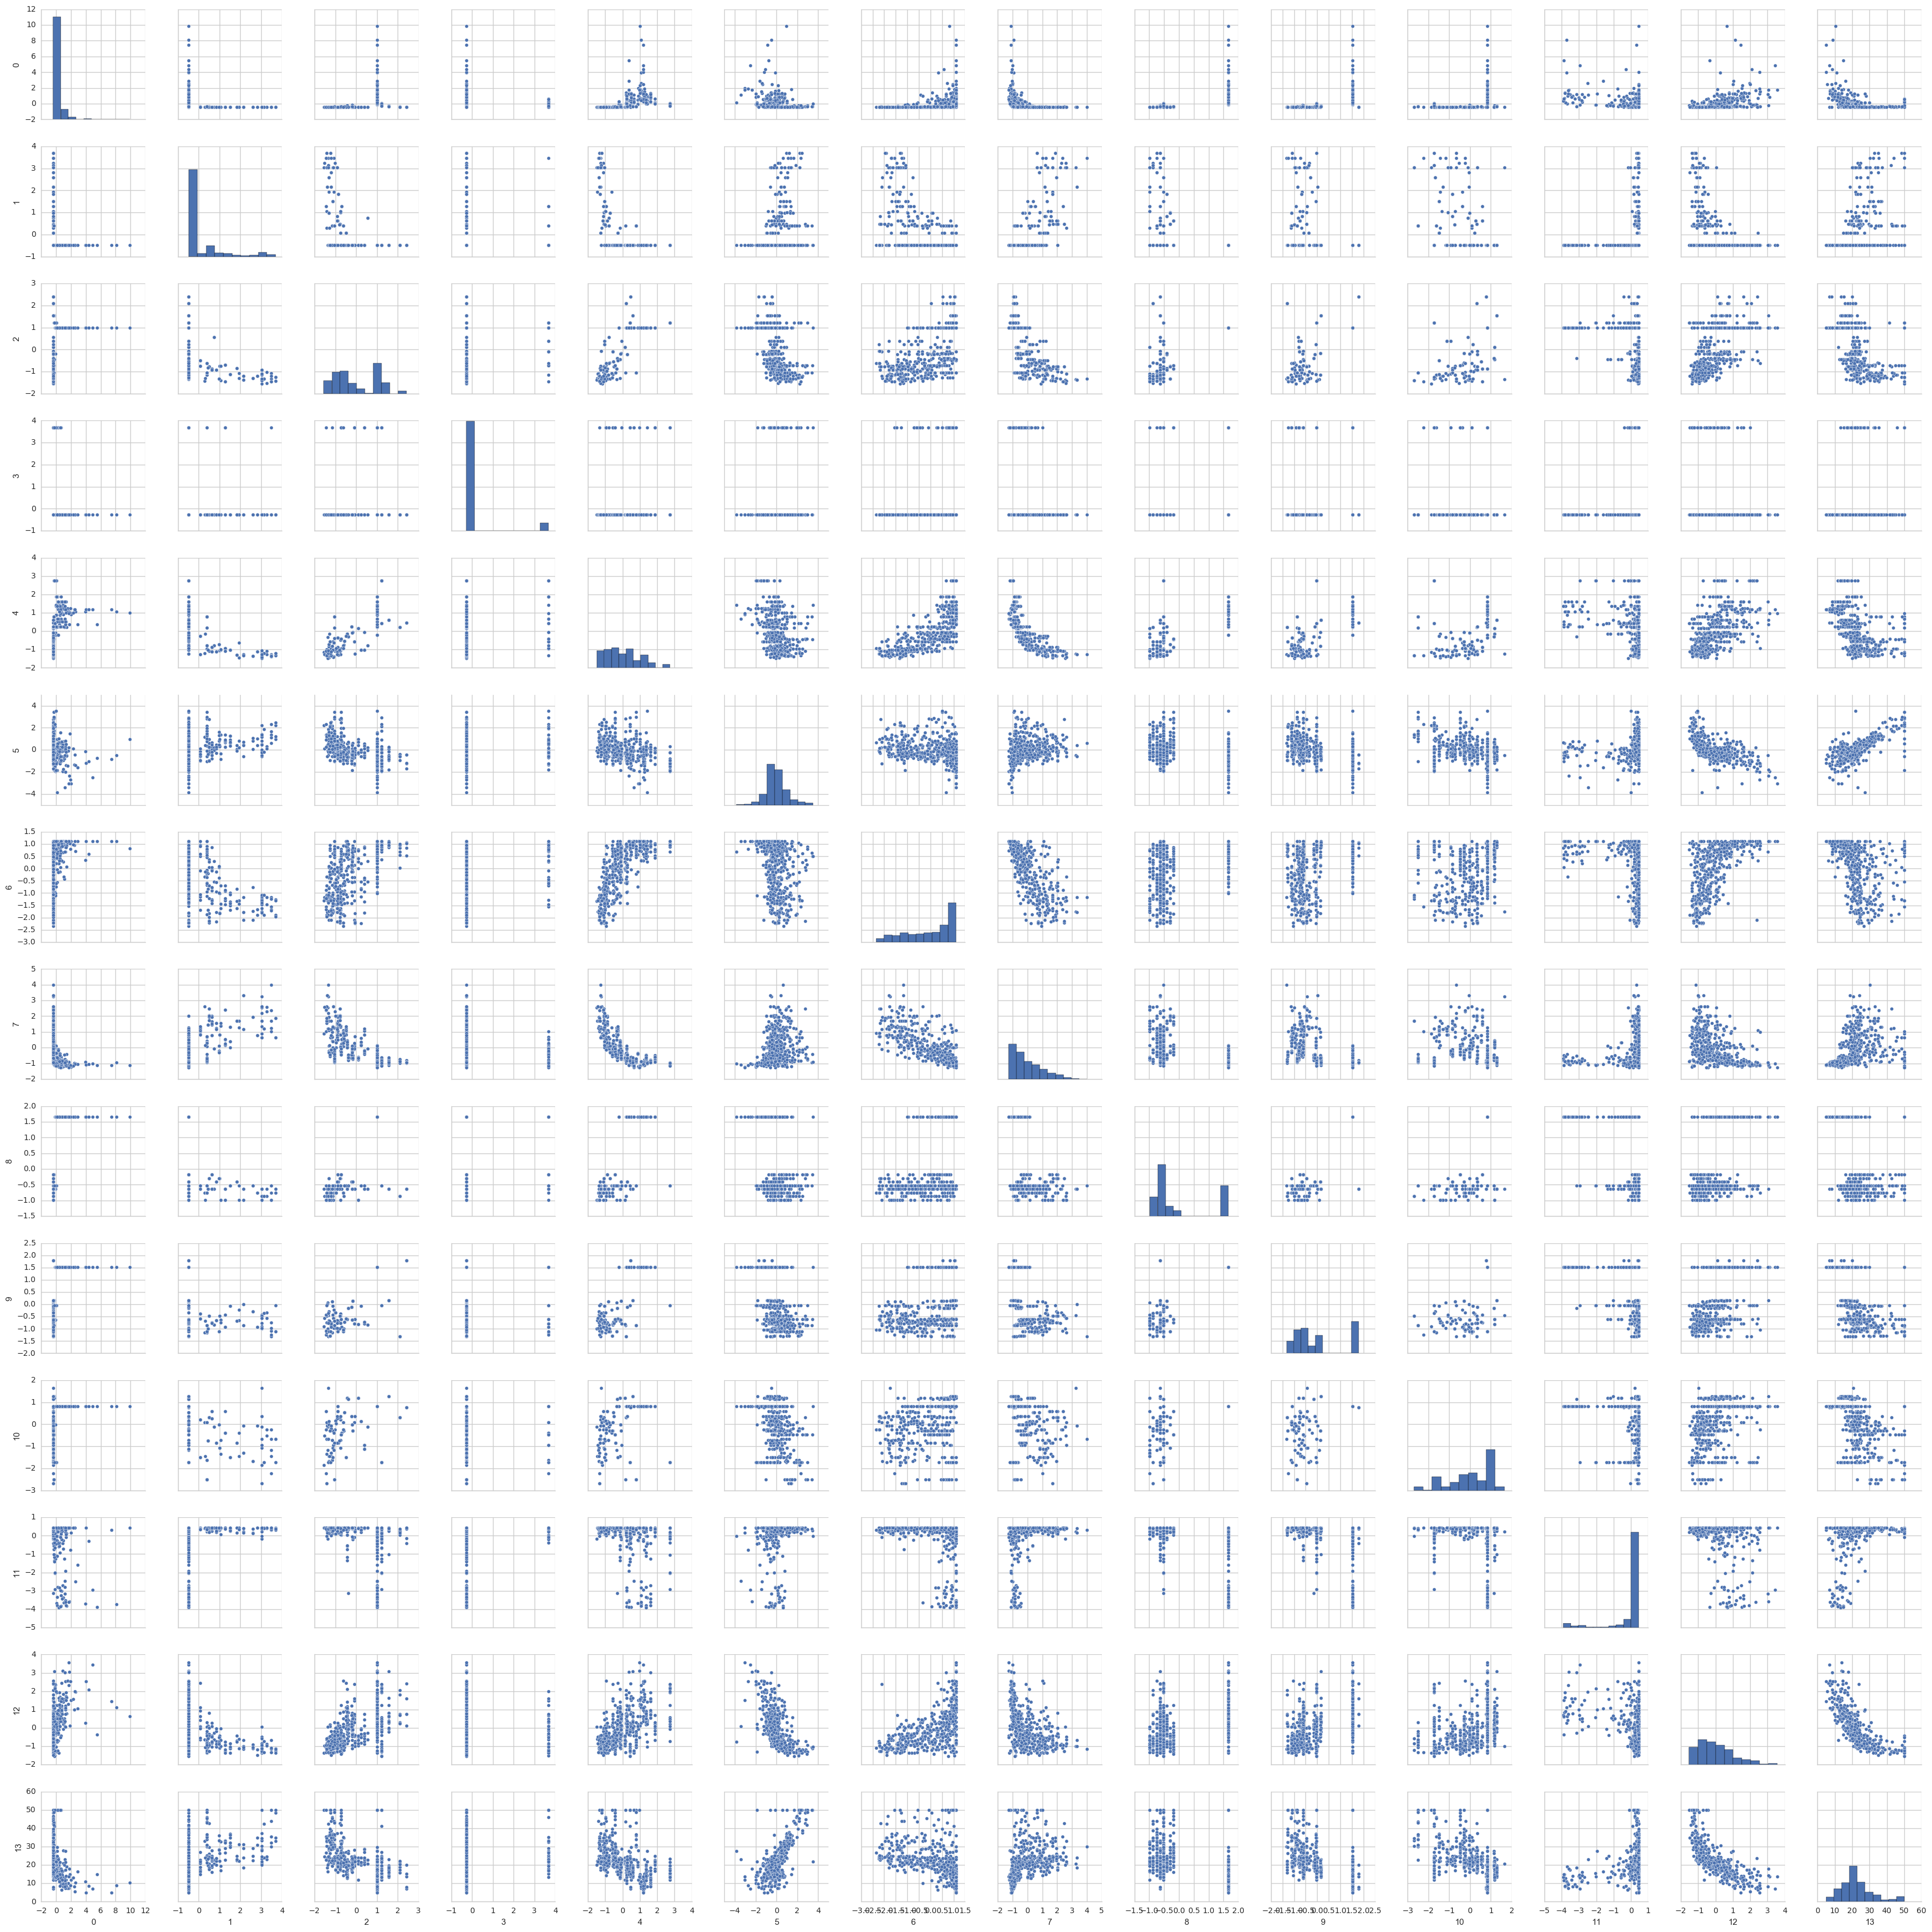

In [31]:
data = np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, size=2.5)
plt.tight_layout()
plt.savefig('./output/fig-housing-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()


Now, prints out the weight $w\_$, to see how each feature contributes to the prediction.

In [32]:
top_feat = np.argsort(np.fabs(llr.w_[1:]))[::-1]
for i in top_feat:
    print("feature #%2d: %.3f" %(i, llr.w_[i+1]))


feature # 5: 0.315
feature #12: -0.308
feature #10: -0.230
feature # 2: -0.199
feature # 4: -0.185
feature # 9: -0.165
feature # 0: -0.155
feature # 6: -0.148
feature # 8: -0.144
feature # 1: 0.143
feature #11: 0.132
feature # 3: 0.092
feature # 7: 0.087


By observing the weights and the figure we plotted above, it's obvious that some useless features still has a very high weights.
We can still apply PCA to do feature extraction.
By examining the explained variance ratio, we can find that some of the features are useless.

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=13)
pca.fit(X_train)
X_pca = pca.transform(X_train)

print(pca.explained_variance_ratio_)


[ 0.46970114  0.11076345  0.09628928  0.0671518   0.06328235  0.04935356
  0.04202514  0.02978913  0.02192406  0.01715434  0.01466155  0.01296957
  0.00493463]


In [67]:
from sklearn.cross_validation import train_test_split

a = 0.001
eta = 0.001
r2_best = 0.5
mse_best = 40
max_iter = 3000
max_alpha = 20
max_comps = 13

candidates = []

while a <= max_alpha:

    X_tune_train, X_val, y_tune_train, y_val = train_test_split(
    X_train, y_train, test_size=0.4, random_state=1)
    X_tune_train = X_val = X_train
    y_tune_train = y_val = y_train

    llr = LassoRegressor(eta=eta, alpha=a, n_iter=max_iter)
    llr = llr.fit(X_tune_train, y_tune_train)
        
    y_val_pred = llr.predict(X_val)
    r2  = r2_score(y_val, y_val_pred)        
    mse = mean_squared_error(y_val, y_val_pred)
        
    if mse < mse_best or r2 > r2_best :
        print('r2 : %.2f, MSE: %.2f, alpha: %.3f' %(r2, mse, a))
        r2_best = r2
        mse_best = mse
        
        candidate = {'model' : llr, 'alpha' : a, 'mse' : mse, 'r2' : r2}
        candidates.append(candidate)
    
    if a < 0.01  : a += 0.001
    elif a < 0.1 : a += 0.01
    elif a < 1   : a += 0.1
    elif a < 10  : a += 0.2
    else         : a += 0.4

print('Finished searching alpha')

r2 : 0.72, MSE: 23.68, alpha: 0.001
Finished searching alpha


In [68]:

sorted_cand = sorted(candidates, key=lambda x : x['mse'])
sorted_cand = sorted(sorted_cand, key=lambda x : x['r2'])[::-1]
sorted_cand = sorted_cand[0:10]

X_test = np.loadtxt('X_test.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')
X_test = sc_x.transform(X_test)

for c in sorted_cand:
    y_test_pred = c['model'].predict(X_test)
    
    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    print("--- alpha: %.5f ---" %(c['alpha']))
    print(" R2 train: %.2f, test: %.2f" %(c['r2'], r2_test))
    print("MSE train: %.2f, test: %.2f" %(c['mse'], mse_test))


--- alpha: 0.00100 ---
 R2 train: 0.72, test: 0.74
MSE train: 23.68, test: 15.17
